In [1]:
import pandas as pd
import numpy as np
import numpy.random as random
import itertools
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
PERSONS = (PA,PB,PC) = ['A','B','C']
PERSONALITIES = (TRUEIST,LIAR,RANDOMIST) = ( 'L', 'T' , 'R')
YES_NO = (YES,NO) = ('YES','NO')
BOOL_TOKENS = (BOOL_X,BOOL_Y) = ['X','Y']

PROBS = pd.DataFrame(
    [(*bt,*lwr) 
        for bt in itertools.permutations( BOOL_TOKENS )
        for lwr in itertools.permutations( PERSONALITIES ) 
    ],columns=[*YES_NO,*PERSONS])
PROBS['P(H)'] = 1/ PROBS.index.size
PROBS

,YES,NO,A,B,C,P(H)
0,X,Y,L,T,R,0.083333
1,X,Y,L,R,T,0.083333
2,X,Y,T,L,R,0.083333
3,X,Y,T,R,L,0.083333
4,X,Y,R,L,T,0.083333
5,X,Y,R,T,L,0.083333
6,Y,X,L,T,R,0.083333
7,Y,X,L,R,T,0.083333
8,Y,X,T,L,R,0.083333
9,Y,X,T,R,L,0.083333


In [3]:
def ask(person,question,h,show_random=False,show_prob=False):
    """ let 'person' answer the 'question', given the state h.
    The (internal) state is a dictonary that maps the a person to a role, 
    and YES/NO to the BOOL_X BOOL_Y representations.
    If the person is a LIAR, the true answer (application of the question to the state)
    gets inverted. If (s)he is a RANDOMIST, the answer is a random draw from BOOL_X and BOOL_Y.
    
    """
    assert person in PERSONS
    true_answer = bool(question(h))

    eff = None
    if h[person] == LIAR:
        eff = h[YES] if not(true_answer) else h[NO]
    elif h[person] == TRUEIST:
        eff = h[YES] if true_answer else h[NO]
    else: 
        assert h[person] == RANDOMIST
        eff = '?' if (show_random or show_prob) else BOOL_TOKENS[random.choice(2)]

    assert eff in BOOL_TOKENS or eff == '?'
    BOOL_X_PROB_BY_EFF = { '?':0.5, BOOL_X:1.0, BOOL_Y:0.0 }
    if show_prob:
        prob_x = BOOL_X_PROB_BY_EFF[eff]
        return { BOOL_X : prob_x, BOOL_Y : 1 - prob_x }
    else:
        return eff
    
class Oracle():
    """ wrapper around a randomly draw state (mapping of persons to roles, and a boolean language)"""
    def __init__(self):
        self.init_hidden()
        
    def init_hidden(self):
        choice = random.choice(PROBS.index.size)
        self.hidden = PROBS.iloc[choice,:]
        self.query_count = 0

    def interview(self,person,question):
        self.query_count += 1
        if self.query_count > 3:
            self.init_hidden()
            raise Exception('failed to solve it in 3 questions ')
        return ask(person,question,h=self.hidden)
        
    def validate(self,randomist=None,trueist=None,liar=None):
        correct = self.hidden[randomist]==RANDOMIST \
            and self.hidden[trueist]==TRUEIST \
            and self.hidden[liar]==LIAR
        self.init_hidden()
        return correct

In [4]:
def question_other_role(interviewed,subject,role):
    """Create a query to 'interviewed' about 'subject' being in a 'role'.
    We use the '^' XOR operation: each operand, if true, inverts the other operands value:
    So if the interviewed is a LIAR, he has to invert its answer, so that (after lying) 
    he speaks the truth. 
    Likewise, to allow us to treat 'Y' as true and 'X' as false, we let him/her invert 
    the answer if 'X' represents True. 
    This allows us to get a correct answer, without knowing the thruth values of 'X' and 'Y',
    or the whether or interviewee is a LIAR. 
    Welcome in an ideal world where being a liar is the same as having another language!
    """
    return  lambda h : (h[subject] == role) ^  \
        ( (h[interviewed] == LIAR) ^ (h[YES] =='X') )

def compute_probs(interviewed,question,expected_answer,priors):
    likelyhoods =  [ ask(interviewed,question,v,show_prob=True)[expected_answer] 
                    for i,v in PROBS.iterrows()] 
    marginal_likelyhood = ( priors * likelyhoods ).sum()
    return ( likelyhoods * priors ) / marginal_likelyhood

def investigate(oracle,logger=print,plotlikelyhood=True):
    
    df = PROBS.copy()
    
    Q1 = question_other_role(PA,PB,RANDOMIST)
    logger ("asking {} wether {} is a RANDOMIST".format(PA,PB))
    ans_Q1 = oracle.interview(PA, Q1)
    p_not_random, p_other = (PB,PC) if ans_Q1 == BOOL_X else (PC,PB)
    logger ("answered {}, so {} is not a RANDOMIST".format(ans_Q1,p_not_random))

    df['P(H|Q1)'] = compute_probs('A',Q1,ans_Q1, df['P(H)'] )
  
    Q2 = question_other_role(p_not_random,p_other,RANDOMIST)
    
    logger ("asking {} wether {} is a RANDOMIST".format(p_not_random,p_other))
    ans_Q2 = oracle.interview(p_not_random, Q2)
    p_random,p_not_r_2 = (PA,p_other) if ans_Q2 == BOOL_X else (p_other,PA)
    logger ("answered {}, so {} is a RANDOMIST".format(ans_Q2,p_random))

    df['P(H|Q1,Q2)'] = compute_probs(p_not_random,Q2,ans_Q2, df['P(H|Q1)'] )
    
    Q3 = question_other_role(p_not_random,p_not_r_2,TRUEIST)
    
    logger ("asking {} wether {} is a TRUEIST".format(p_not_random,p_not_r_2))
    ans_Q3 = oracle.interview(p_not_random, Q3)
    r , t , l = (p_random,p_not_random,p_not_r_2) if ans_Q3 == BOOL_X else (p_random,p_not_r_2,p_not_random)
    logger ("answered {}, so {} is a RANDOMIST,{} a TRUEIST, and {} a LIAR?".format(ans_Q3,r,t,l))

    df['P(H|Q1,Q2,Q3)'] = compute_probs(p_not_random,Q3,ans_Q3, df['P(H|Q1,Q2)'] )

    correct = oracle.validate(randomist=r,trueist=t,liar=l)
    logger ( "CORRECT!" if correct else "INCORRECT! {}".format(oracle.hidden) )
    
    if plotlikelyhood:
        fig,ax = plt.subplots(figsize=(12,6))
        df = df.set_index([ *YES_NO, *PERSONS ])
        df.T.plot(kind='barh', stacked=True,ax=ax)
        ax.legend(title=df.index.names,loc='right',bbox_to_anchor=(1.2,0.5))
        ax.invert_yaxis()
        plt.show()
        display(df)
    return correct


asking A wether B is a RANDOMIST
answered Y, so C is not a RANDOMIST
asking C wether B is a RANDOMIST
answered Y, so B is a RANDOMIST
asking C wether A is a TRUEIST
answered X, so B is a RANDOMIST,C a TRUEIST, and A a LIAR?
CORRECT!


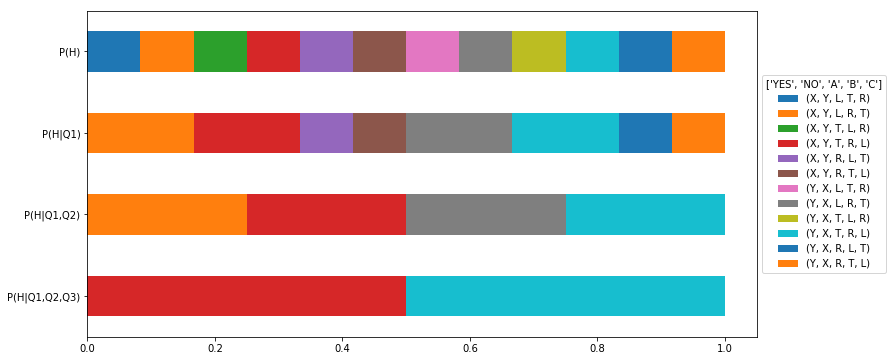

P(H)   P(H|Q1)  P(H|Q1,Q2)  P(H|Q1,Q2,Q3)
YES NO A B C                                               
X   Y  L T R  0.083333  0.000000        0.00            0.0
         R T  0.083333  0.166667        0.25            0.0
       T L R  0.083333  0.000000        0.00            0.0
         R L  0.083333  0.166667        0.25            0.5
       R L T  0.083333  0.083333        0.00            0.0
         T L  0.083333  0.083333        0.00            0.0
Y   X  L T R  0.083333  0.000000        0.00            0.0
         R T  0.083333  0.166667        0.25            0.0
       T L R  0.083333  0.000000        0.00            0.0
         R L  0.083333  0.166667        0.25            0.5
       R L T  0.083333  0.083333        0.00            0.0
         T L  0.083333  0.083333        0.00            0.0

True


In [5]:
oracle = Oracle()
no_failure = investigate(oracle)
for i in range(0,100):
    no_failure = no_failure and investigate(oracle, lambda s: s,plotlikelyhood=False)
print(no_failure)

In [6]:
df = PROBS.copy()
     
Q1 = question_other_role(PA,PB,RANDOMIST)
df['P(H|Q1=X)'] = compute_probs('A',Q1,BOOL_X, df['P(H)'] )
df['P(H|Q1=Y)'] = compute_probs('A',Q1,BOOL_Y, df['P(H)'] )

Q2_Q1X = question_other_role(PB,PC,RANDOMIST)
df['P(H|Q1=X,Q2=X)'] = compute_probs('B',Q2_Q1X,BOOL_X, df['P(H|Q1=X)'] )
df['P(H|Q1=X,Q2=Y)'] = compute_probs('B',Q2_Q1X,BOOL_Y, df['P(H|Q1=X)'] )

Q2_Q1Y = question_other_role(PC,PB,RANDOMIST)
df['P(H|Q1=Y,Q2=X)'] = compute_probs('C',Q2_Q1Y,BOOL_X, df['P(H|Q1=Y)'] )
df['P(H|Q1=Y,Q2=Y)'] = compute_probs('C',Q2_Q1Y,BOOL_Y, df['P(H|Q1=Y)'] )

Q3_Q2X_Q1X = question_other_role(PB,PC,TRUEIST)
df['P(H|Q1=X,Q2=X,Q3=X)'] = compute_probs('B',Q3_Q2X_Q1X,BOOL_X, df['P(H|Q1=X,Q2=X)'] )
df['P(H|Q1=X,Q2=X,Q3=Y)'] = compute_probs('B',Q3_Q2X_Q1X,BOOL_Y, df['P(H|Q1=X,Q2=X)'] )

Q3_Q2Y_Q1X = question_other_role(PB,PA,TRUEIST)
df['P(H|Q1=X,Q2=Y,Q3=X)'] = compute_probs('B',Q3_Q2Y_Q1X,BOOL_X, df['P(H|Q1=X,Q2=Y)'] )
df['P(H|Q1=X,Q2=Y,Q3=Y)'] = compute_probs('B',Q3_Q2Y_Q1X,BOOL_Y, df['P(H|Q1=X,Q2=Y)'] )

Q3_Q2X_Q1Y = question_other_role(PC,PC,TRUEIST)
df['P(H|Q1=Y,Q2=X,Q3=X)'] = compute_probs('C',Q3_Q2X_Q1Y,BOOL_X, df['P(H|Q1=Y,Q2=X)'] )
df['P(H|Q1=Y,Q2=X,Q3=Y)'] = compute_probs('C',Q3_Q2X_Q1Y,BOOL_Y, df['P(H|Q1=Y,Q2=X)'] )

Q3_Q2Y_Q1Y = question_other_role(PC,PA,TRUEIST)
df['P(H|Q1=Y,Q2=Y,Q3=X)'] = compute_probs('C',Q3_Q2Y_Q1Y,BOOL_X, df['P(H|Q1=Y,Q2=Y)'] )
df['P(H|Q1=Y,Q2=Y,Q3=Y)'] = compute_probs('C',Q3_Q2Y_Q1Y,BOOL_Y, df['P(H|Q1=Y,Q2=Y)'] )


#df['Q1=X,Q2'] = [ ask('B',Q2_Q1X,v,show_random=True) for i,v in df.iterrows()] 

In [7]:
df

,YES,NO,A,B,C,P(H),P(H|Q1=X),P(H|Q1=Y),"P(H|Q1=X,Q2=X)","P(H|Q1=X,Q2=Y)","P(H|Q1=Y,Q2=X)","P(H|Q1=Y,Q2=Y)","P(H|Q1=X,Q2=X,Q3=X)","P(H|Q1=X,Q2=X,Q3=Y)","P(H|Q1=X,Q2=Y,Q3=X)","P(H|Q1=X,Q2=Y,Q3=Y)","P(H|Q1=Y,Q2=X,Q3=X)","P(H|Q1=Y,Q2=X,Q3=Y)","P(H|Q1=Y,Q2=Y,Q3=X)","P(H|Q1=Y,Q2=Y,Q3=Y)"
0,X,Y,L,T,R,0.083333,0.166667,0.000000,0.00,0.25,0.00,0.00,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,X,Y,L,R,T,0.083333,0.000000,0.166667,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,X,Y,T,L,R,0.083333,0.166667,0.000000,0.00,0.25,0.00,0.00,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,X,Y,T,R,L,0.083333,0.000000,0.166667,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
4,X,Y,R,L,T,0.083333,0.083333,0.083333,0.25,0.00,0.25,0.00,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0
5,X,Y,R,T,L,0.083333,0.083333,0.083333,0.25,0.00,0.25,0.00,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0
6,Y,X,L,T,R,0.083333,0.166667,0.000000,0.00,0.25,0.00,0.00,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
7,Y,X,L,R,T,0.083333,0.000000,0.166667,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,Y,X,T,L,R,0.083333,0.166667,0.000000,0.00,0.25,0.00,0.00,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
9,Y,X,T,R,L,0.083333,0.000000,0.166667,0.00,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


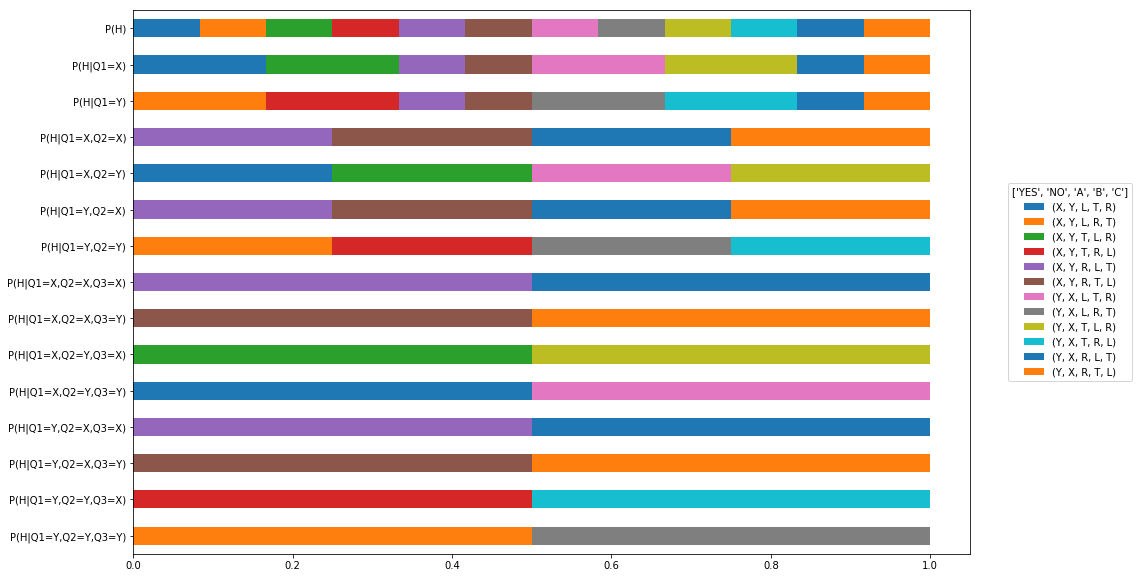

In [8]:
fig,ax = plt.subplots(figsize=(15,10))
df2 = df.set_index([ *YES_NO, *PERSONS ])
df2.T.plot(kind='barh', stacked=True,ax=ax)
ax.legend(title=df2.index.names,loc='right',bbox_to_anchor=(1.2,0.5))
ax.invert_yaxis()
plt.show()